# **1. Data Loading**

In [1]:
# enable importing nflmodels package
import sys
sys.path.append('..') 


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, cohen_kappa_score, roc_auc_score, mean_squared_error, log_loss, RocCurveDisplay, f1_score

import xgboost as xgb

import seaborn as sns
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)

from joblib import dump, load

# DEV: reload modules
import importlib
importlib.reload(sys.modules.get('nflmodels.createmodel', sys))
importlib.reload(sys.modules.get('nflmodels.preprocessing', sys))
importlib.reload(sys.modules.get('nflmodels.dataloading', sys))

from nflmodels.preprocessing import preprocess_next_play, preprocess_field_goal, preprocess_ep
from nflmodels.dataloading import load_data_postgresql
from nflmodels.createmodel import create_field_goal_predictor, create_next_play_predictor

In [2]:
df = load_data_postgresql(min_season=2010, max_season=2022, verbose=False)

c:\Users\Eemeli\Documents\GitHub\nflmodels\notebooks\..\nflmodels\dataloading.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql=query, con=conn)


# **2. Play Type Prediction - ML**

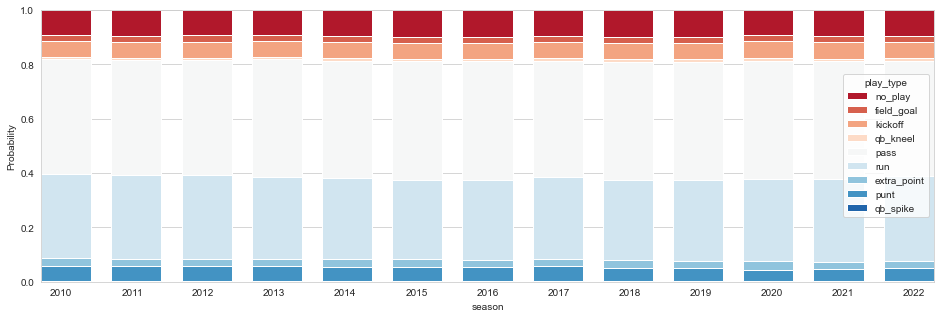

In [3]:
# plot play types per season
fig, ax = plt.subplots(figsize=(16,5))
sns.histplot(data=df, x='season', hue='play_type', stat='probability', multiple='fill', shrink=5, palette='RdBu', ax=ax, alpha=1)
ax.set_xticks([*range(df['season'].min(), df['season'].max() + 1, 1)])
plt.show()

Play types are distributed similarly in all seasons featured here.

In [4]:
# # preliminary testing shows that weighting only increased the errors in past seasons, does not really influence performance on recent data
# USE_SAMPLE_WEIGHTS = False

# if USE_SAMPLE_WEIGHTS:
#     # create sample weights
#     df_plays['sample_weights'] = 1

#     n_of_seasons = df_plays['season'].max() - df_plays['season'].min() + 1

#     for i in range(n_of_seasons):
#         season = df_plays['season'].max() - i
#         #sample_weights['sample_weights'] = np.where(sample_weights['season'] == season, 1 / n_of_seasons * (n_of_seasons - i), sample_weights['sample_weights'])
#         # if i < 3:
#         df_plays['sample_weights'] = np.where(df_plays['season'] == season,  5 / (n_of_seasons ** 2) * ((n_of_seasons - i) ** 2), df_plays['sample_weights'])
#         # else:
#         #     sample_weights['sample_weights'] = np.where(sample_weights['season'] == season,  1 / 169 * ((n_of_seasons - i) * (n_of_seasons - i)), sample_weights['sample_weights'])
# else:
#     df_plays['sample_weights'] = 1


In [5]:
# subquery_args = [
# #    'season >= 2022',
# #    'posteam == "KC"'
# ]

# subquery = ' and '.join(subquery_args)

# # Feature selection --------------------

# features = [
#     'sample_weights',
#     #'posteam_score', 
#     #'defteam_score', 
#     'score_differential', 
#     'qtr', 
#     'game_seconds_remaining', 
#     'half_seconds_remaining', 
#     'down', 
#     'yardline_100', 
#     'ydstogo', 
#     'goal_to_go', 
#     'posteam_timeouts_remaining', 
#     'defteam_timeouts_remaining', 
#     'posteam_type', 
#     'shotgun',
#     #'posteam',
#     #'defteam',
#     ]

# if subquery == '':
#     y = df_plays['play_type']
#     X = df_plays[features]
# else:
#     y = df_plays.query(subquery)['play_type']
#     X = df_plays.query(subquery)[features]

# # Feature engineering ------------------

# # - encode categoricals
# X = pd.get_dummies(X, columns=[
#     'qtr', 
#     'down', 
#     'posteam_timeouts_remaining', 
#     'defteam_timeouts_remaining', 
#     #'posteam',
#     #'defteam',
#     ])

# sample_weights = X['sample_weights'].to_numpy()
# X.drop('sample_weights', axis=1, inplace=True)

### Train-val-test

In [6]:
X, y, labels = preprocess_next_play(data=df, seasons=[], return_X_y=True, map_target_to_int=True, include_fg=True, include_qbkneel=False, include_qbspike=False, verbose=True)

# split train_val_test 60-20-20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

Preprocessing 627301 rows...
Preprocessing for play types: ['pass', 'run', 'field_goal', 'punt']
Dropped 1250 rows containing NaN values.
Resulting dataset size is 482165 rows.
Encoding play types as integers...
Returned preprocessed X, y, play_types


### XGBClassifier

On validation set
ROC AUC: 0.848
F1 score: 0.750
MSE: 0.260
Log loss: 0.498


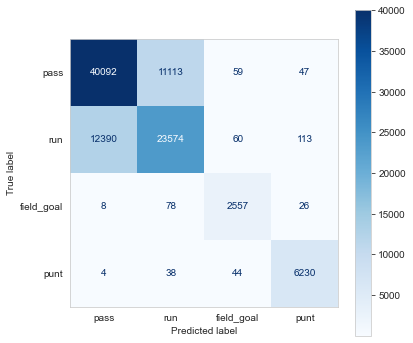

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     51311
           1       0.68      0.65      0.66     36137
           2       0.94      0.96      0.95      2669
           3       0.97      0.99      0.98      6316

    accuracy                           0.75     96433
   macro avg       0.84      0.84      0.84     96433
weighted avg       0.75      0.75      0.75     96433

Cohen kappa score: 0.564


In [7]:
clf, y_pred, y_pred_proba = create_next_play_predictor(X_train, y_train, X_val, y_val, print_val_metrics=True)

# plot prediction results
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, values_format='.5g')
ax.grid(False)
plt.show()

# print prediction metrics
print(classification_report(y_val, y_pred))
print('Cohen kappa score: {:.3f}'.format(cohen_kappa_score(y_val, y_pred)))

# **3. Field Goal Success Prediction - ML**

### Preprocess & Train test split

In [33]:
X, y = preprocess_field_goal(data=df, kickers='active', return_X_y=True)

# Split train-val-test: 70%/12.5%/12.5%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

### Model training

On validation set
ROC AUC: 0.818
MSE: 0.092
Log loss: 0.250


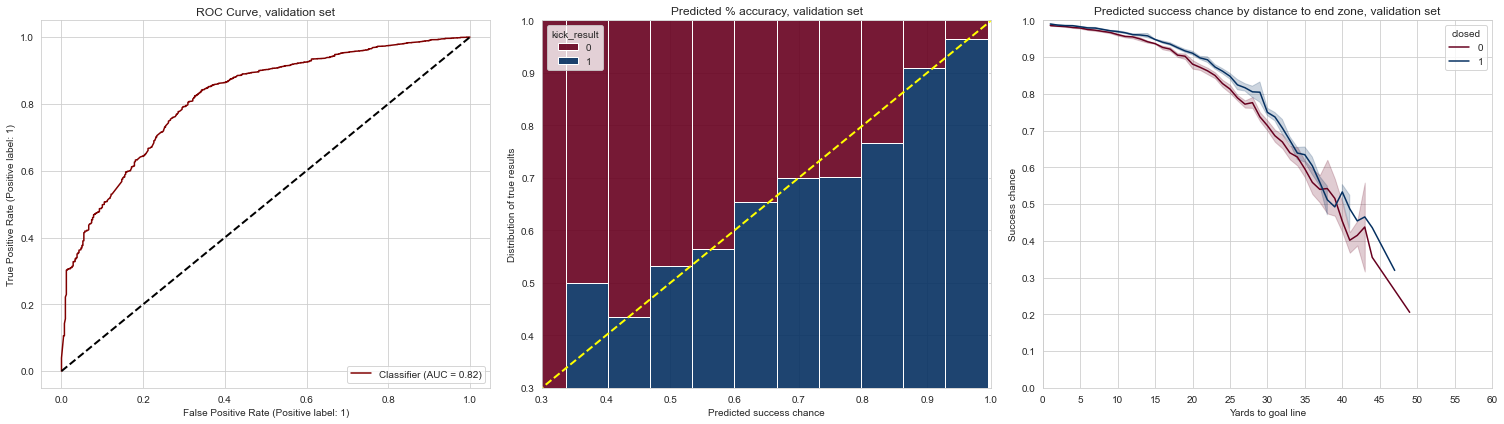

In [9]:
clf, y_pred, y_pred_proba = create_field_goal_predictor(X_train, y_train, X_val, y_val, print_val_metrics=True)

# =-=-=-=-= Plot metrics: =-=-=-=-=
fig, ax = plt.subplots(1, 3, figsize=(21,6))

# 1. ROC curve
RocCurveDisplay.from_predictions(y_val, y_pred_proba[:,1], ax=ax[0], color='maroon')
ax[0].set_title('ROC Curve, validation set')
ax[0].plot([0,1], [0,1], color='black', linestyle='--', linewidth=2)

# 2. Accuracy of predicted probabilities
# For predicted success %, what portion of attempts were actually successful
# Yellow line decipts optimal performance where the predicted success chance matches the proportion of successful attempts 
sns.histplot(x=y_pred_proba[:,1], hue=y_val, ax=ax[1], multiple='fill', stat='probability', palette='RdBu', hue_norm=(0,1), bins=12, alpha=0.9)
ax[1].plot([0,1], [0,1], color='yellow', linestyle='--', linewidth=2)
ax[1].set_xlim(0.3, 1)
ax[1].set_ylim(0.3, 1)
ax[1].set_xlabel('Predicted success chance')
ax[1].set_ylabel('Distribution of true results')
ax[1].set_title('Predicted % accuracy, validation set')

# 3. Predicted success by distance to end zone, validation set
sns.lineplot(data=X_val, x='yardline_100', y=y_pred_proba[:,1], ax=ax[2], palette='RdBu', hue_norm=(0,1), #legend=None,
             #hue=X_val[[item for item in list(clf.feature_names_in_) if item.startswith('kicker_player_name_')]].idxmax(axis=1).str.split('_').str[-1]
             hue='closed'
             )
ax[2].set_ylabel('Success chance')
ax[2].set_xlabel('Yards to goal line')
ax[2].set_ylim(0,1)
ax[2].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[2].set_xlim(0, 60)
ax[2].set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
ax[2].set_title('Predicted success chance by distance to end zone, validation set')

plt.tight_layout()
plt.show()

In [10]:
# 1. Retrain using train + val
# 2. Test on test set
# 3. Save model using joblib

# Logistic regression, train + val
clf_fg = LogisticRegression(max_iter=1000)
clf_fg.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))

# Predict on test set
y_pred = clf_fg.predict(X_test)
y_pred_proba = clf_fg.predict_proba(X_test)

# Print classification report
print('On test set')
print('ROC AUC: {:.3f}      MSE: {:.3f}     Log loss: {:.3f}'.format(roc_auc_score(y_test, y_pred_proba[:,1]), mean_squared_error(y_test, y_pred), log_loss(y_test, y_pred_proba)))

# Save model to disk
dump(clf_fg, 'clf_fg.joblib')
print('Model saved!')
#load('clf_fg.joblib') # to load saved model

On test set
ROC AUC: 0.797      MSE: 0.090     Log loss: 0.251
Model saved!


### Using the Model

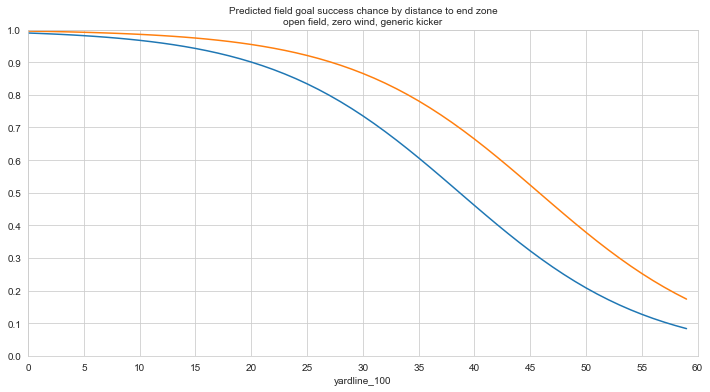

In [11]:
# simulated kicks, open air field, no wind, generic kicker
ydline = [*range(0, 60, 1)]
pred_df = pd.DataFrame({'yardline_100': ydline})
for i in range(1, len(clf.feature_names_in_)): #start from 1 to skip yardline
    pred_df[clf.feature_names_in_[i]] = 0
pred_df['kicker_player_name_Other'] = 1 #use other player for all predictions
#pred_df['closed'] = 1
#pred_df['wind'] = 15

pred_res = clf.predict_proba(pred_df)[:,1]#.reshape(-1, 1)

# J.Tucker
pred_df['kicker_player_name_Other'] = 0
pred_df['kicker_player_name_J.Tucker'] = 1
pred_res_jt = clf.predict_proba(pred_df)[:,1]

# plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(ax=ax, data=pred_df, x='yardline_100', y=pred_res)
sns.lineplot(ax=ax, data=pred_df, x='yardline_100', y=pred_res_jt)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
ax.set_ylim(0, 1)
ax.set_xlim(0, 60)
ax.set_title('Predicted field goal success chance by distance to end zone\nopen field, zero wind, generic kicker', size=10)
plt.show()

# **4. EP & EPA**

ep = expected points

In [3]:
df.info()
# [['game_id', 'play_id', 'qtr', 'game_half', 'posteam', 'defteam', 'drive', 'down', 'yardline_100', 'play_type', 
#                               'penalty', 'timeout', 'sp', 'posteam_score', 'defteam_score', 'play_score_gained', 'next_score', 'ep', 'epa']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630069 entries, 0 to 630068
Data columns (total 83 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     630069 non-null  int64  
 1   game_id                     630069 non-null  object 
 2   home_team                   630069 non-null  object 
 3   away_team                   630069 non-null  object 
 4   posteam                     583989 non-null  object 
 5   posteam_type                583989 non-null  object 
 6   defteam                     583989 non-null  object 
 7   yardline_100                577420 non-null  float64
 8   quarter_seconds_remaining   629515 non-null  float64
 9   half_seconds_remaining      629515 non-null  float64
 10  game_seconds_remaining      629515 non-null  float64
 11  quarter_end                 630069 non-null  int64  
 12  drive                       620345 non-null  float64
 13  sp            

In [16]:
# TODO: temp, remove after not needed
importlib.reload(sys.modules.get('nflmodels.preprocessing', sys))
from nflmodels.preprocessing import preprocess_ep

df_ep = preprocess_ep(data=df)

Preprocessing 630069 rows...
After dropping some rows, dataset size is 577021
All 577021 out of 577021 rows processed!
Final dataset size is 576998 rows


In [14]:
df_ep['next_score'].value_counts()

td               187590
fg               140055
no_score          88751
opp_td            85109
opp_fg            55228
pat               16130
safety             1933
opp_safety         1500
2pat                691
opp_patreturn        11
Name: next_score, dtype: int64

In [17]:
df_ep['next_score_value'].value_counts()

 6    187590
 3    140055
 0     88751
-6     85109
-3     55228
 1     16130
 2      2624
-2      1511
Name: next_score_value, dtype: int64

In [12]:
df_ep.query('field_goal_attempt == 1')[['next_score','sp','yardline_100', 'play_score_gained','ep','epa', 'play_type']].head(60)

,next_score,sp,yardline_100,play_score_gained,ep,epa,play_type
13,opp_fg,0,16.0,None,2.690119,-4.517740,field_goal
40,fg,1,4.0,3.0,2.937339,0.062661,field_goal
63,fg,1,28.0,3.0,1.932867,1.067133,field_goal
108,fg,1,7.0,3.0,2.890051,0.109949,field_goal
192,fg,1,34.0,3.0,0.835992,2.164008,field_goal
245,fg,0,28.0,None,1.843330,-3.219873,field_goal
253,opp_fg,0,37.0,None,1.155874,-1.864610,field_goal
257,fg,1,31.0,3.0,1.994863,1.005137,field_goal
272,fg,1,21.0,3.0,2.336894,0.663106,field_goal
280,fg,1,18.0,3.0,2.410303,0.589697,field_goal


One possibility would be to assess extra point attempts differently and obtain a reasonable expectation on the value. Then this value would be used with tds to increase their value and drop extra point attempts completely...?

Issues:
nflverse says that the value of a touchdown is always seven, meaning that on a td ep+epa=7

In [26]:
#df_ep.query('game_id == "2022_18_TEN_JAX"').groupby('posteam')['epa'].sum()
df_ep.query('season == 2022 and play_score_gained == 3')[['ep', 'epa']].head(30)

,ep,epa
533297,2.948091,0.051909
533342,2.193322,0.806678
533479,2.222366,0.777634
533507,1.772887,1.227113
533666,2.921587,0.078413
533685,2.723580,0.276420
533720,2.608476,0.391524
533741,2.734776,0.265224
533749,1.204142,1.795858
533771,2.842867,0.157133
